If you are Chinese, you can check out my [blog](https://blog.csdn.net/qq_33758867/article/details/87794848) .

***Module Imports***

In [145]:
# data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# algorithm
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
# training训练
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

***Load Data***

In [146]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

***data analysis***

**1、SalePrice distribution**

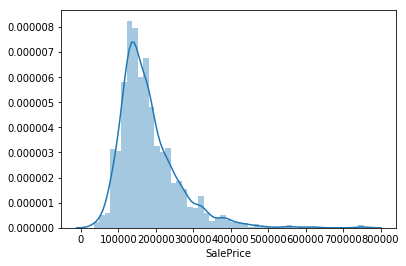

In [147]:
sns.distplot(train.SalePrice)

It can be seen that SalePrice deviates from the normal distribution.We can correct this with a simple log transformation.

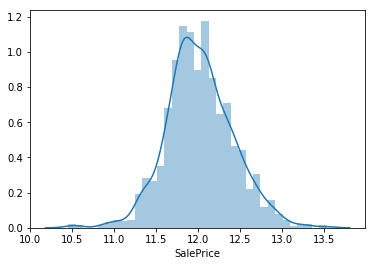

In [148]:
sns.distplot(np.log(train.SalePrice + 1))

**2、Missing value**
（refer to [Top 2% of LeaderBoard - Advanced FE](https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe)）

*Splicing data and visualizing the number of missing values*

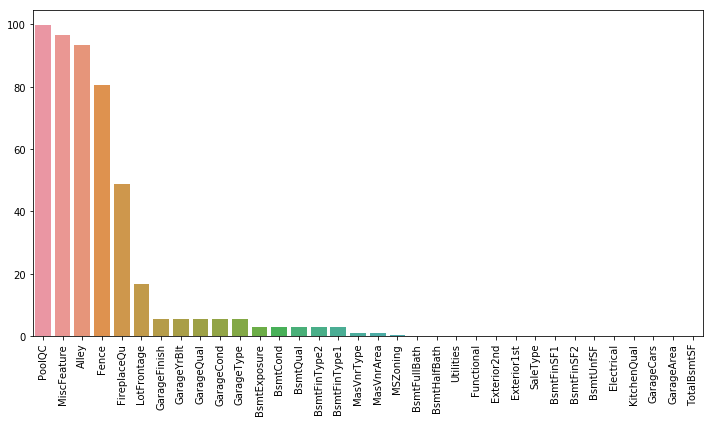

In [149]:
all_data = pd.concat((train.drop(["SalePrice"], axis=1), test))
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index, y=all_data_na)

**PoolQC**：PoolQC has too many missing values. According to the file, there is no swimming pool. You can use **None to fill in missing values**.In theory, the PoolArea corresponding to the missing value of PoolQC should be 0, but after observing a few PoolAreas, it is found that the test set **960, 1043, 1139** are very special. These three examples cannot be filled with None.Of the 13 data, Ex appeared 4 times, Gd appeared 4 times, and Fa appeared 2 times. According to the idea of average distribution, **there are two missing values that need to be filled with Fa**.

In [150]:
all_data[all_data.PoolArea != 0][["PoolArea", "PoolQC"]]

,PoolArea,PoolQC
197,512,Ex
810,648,Fa
1170,576,Gd
1182,555,Ex
1298,480,Gd
1386,519,Fa
1423,738,Gd
514,144,Ex
960,368,NaN
1043,444,NaN


**MiscFeature**：**delete**. According to the file, you can use None to fill in missing values.I also explored the relationship between MiscFeature and its corresponding MiscVal and GarageType, tried some filling methods, and even determined that the example in the test set 1089 should be filled with Gar2, but eventually deleting the feature works better for my model.

In [151]:
all_data[all_data.MiscVal > 10000][["MiscFeature", "MiscVal"]]

,MiscFeature,MiscVal
346,Gar2,15500
1,Gar2,12500
1089,NaN,17000


**Alley**：According to the file, you can use **None to fill** in missing values.

**Fence**：As MiscFeature, **delete**.

**FireplaceQu**：According to the file, you can use **None to fill** in missing values.

**LotFrontage**：This is the object that many Kernels focus on, such as predicted by a useful algorithm, group by Neighborhood and filled with MICE. After my observation,** I think the more reasonable filling method is filled with LotConfig and Neighborhood**, but unfortunately, these filling methods have no effect on my model. **What really works for this model is 0**.

**Garage**：According to the file, **GarageType,GarageFinish,GarageQual,GarageCond fill None, GarageYrBlt,GarageCars,GarageArea fill 0**。But by observing, **there are some unusual examples in the test set that can't be filled like this. It will be filled with median and mode**. Of course, I also tried the filling method that I think is more reasonable, for example, by filling with Neighborhood and GarageType, but the effect is not ideal.

In [152]:
all_data[(all_data.GarageType.notnull()) & (all_data.GarageYrBlt.isnull())][["Neighborhood", "YearBuilt", "YearRemodAdd", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond"]]

,Neighborhood,YearBuilt,YearRemodAdd,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,OldTown,1910,1983,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
1116,IDOTRR,1923,1999,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


**Bsmt**：According to the file, **fill with None or 0**. There are also some special examples below that should not be filled like this, I have tried other filling methods, but in the end I chose to fill with None or 0.

In [153]:
train.loc[[332, 948]][["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath
332,Gd,TA,No,GLQ,1124,NaN,479,1603,1,0
948,Gd,TA,NaN,Unf,0,Unf,0,936,0,0


In [154]:
test.loc[[27, 580, 725, 757, 758, 888, 1064]][["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "BsmtFullBath", "BsmtHalfBath"]]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,BsmtFullBath,BsmtHalfBath
27,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,0.0,0.0
580,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1.0,0.0
725,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,0.0,1.0
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,0.0,0.0
888,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,0.0,0.0
1064,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,0.0,0.0


**MSZoning**：**Fill with mode value RL**. I also tried to fill by MSSubClass, but it didn't work.

**MasVnrType**：**None**

**MasVnrArea**：**0**

**Utilities**：There is no NoSeWa in the test set, basically no effect on SalePrice, **delete**.

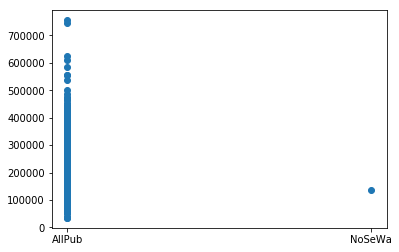

In [155]:
plt.scatter(train.Utilities, train.SalePrice)

**Missing values for the remaining features are filled with mode values**

**There are many ways to fill in missing values. You can try more, explore more, and find the best filling method for your model.**

***feature engineering***

**1、correct SalePrice with a simple log transformation.**

In [156]:
y = train["SalePrice"]

# hofeshk FIX
y = np.log(y+1)

# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

# lam = boxcox_normmax(y)
# y = boxcox1p(y, lam)

# print(f'optimal lambda: {lam}')


**2、Special example missing value filling**

In [157]:
# PoolQC
test.loc[960, "PoolQC"] = "Fa"
test.loc[1043, "PoolQC"] = "Gd"
test.loc[1139, "PoolQC"] = "Fa"
 
# Garage
test.loc[666, "GarageYrBlt"] = 1979
test.loc[1116, "GarageYrBlt"] = 1979
 
test.loc[666, "GarageFinish"] = "Unf"
test.loc[1116, "GarageFinish"] = "Unf"
 
test.loc[1116, "GarageCars"] = 2
test.loc[1116, "GarageArea"] = 480
 
test.loc[666, "GarageQual"] = "TA"
test.loc[1116, "GarageQual"] = "TA"
 
test.loc[666, "GarageCond"] = "TA"
test.loc[1116, "GarageCond"] = "TA"

**3、Missing value filling**

In [158]:
# PoolQC
train = train.fillna({"PoolQC": "None"})
test = test.fillna({"PoolQC": "None"})
 
# Alley
train = train.fillna({"Alley": "None"})
test = test.fillna({"Alley": "None"})
 
# FireplaceQu
train = train.fillna({"FireplaceQu": "None"})
test = test.fillna({"FireplaceQu": "None"})
 
# LotFrontage
train = train.fillna({"LotFrontage": 0})
test = test.fillna({"LotFrontage": 0})
 
# Garage
train = train.fillna({"GarageType": "None"})
test = test.fillna({"GarageType": "None"})
train = train.fillna({"GarageYrBlt": 0})
test = test.fillna({"GarageYrBlt": 0})
train = train.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageFinish": "None"})
test = test.fillna({"GarageCars": 0})
test = test.fillna({"GarageArea": 0})
train = train.fillna({"GarageQual": "None"})
test = test.fillna({"GarageQual": "None"})
train = train.fillna({"GarageCond": "None"})
test = test.fillna({"GarageCond": "None"})
 
# Bsmt
train = train.fillna({"BsmtQual": "None"})
test = test.fillna({"BsmtQual": "None"})
train = train.fillna({"BsmtCond": "None"})
test = test.fillna({"BsmtCond": "None"})
train = train.fillna({"BsmtExposure": "None"})
test = test.fillna({"BsmtExposure": "None"})
train = train.fillna({"BsmtFinType1": "None"})
test = test.fillna({"BsmtFinType1": "None"})
train = train.fillna({"BsmtFinSF1": 0})
test = test.fillna({"BsmtFinSF1": 0})
train = train.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinType2": "None"})
test = test.fillna({"BsmtFinSF2": 0})
test = test.fillna({"BsmtUnfSF": 0})
test = test.fillna({"TotalBsmtSF": 0})
test = test.fillna({"BsmtFullBath": 0})
test = test.fillna({"BsmtHalfBath": 0})
 
# MasVnr
train = train.fillna({"MasVnrType": "None"})
test = test.fillna({"MasVnrType": "None"})
train = train.fillna({"MasVnrArea": 0})
test = test.fillna({"MasVnrArea": 0})
 
# MiscFeature,Fence,Utilities
train = train.drop(["Fence", "MiscFeature", "Utilities"], axis=1)
test = test.drop(["Fence", "MiscFeature", "Utilities"], axis=1)
 
# other
test = test.fillna({"MSZoning": "RL"})
test = test.fillna({"Exterior1st": "VinylSd"})
test = test.fillna({"Exterior2nd": "VinylSd"})
train = train.fillna({"Electrical": "SBrkr"})
test = test.fillna({"KitchenQual": "TA"})
test = test.fillna({"Functional": "Typ"})
test = test.fillna({"SaleType": "WD"})

**4、Explore outliers and delete**(The method of exploring outliers is based on [Top 7% using ElasticNet with Interactions](https://www.kaggle.com/jack89roberts/top-7-using-elasticnet-with-interactions). I used Ridge and ElasticNet to train the training set and predict the training set. Find out the samples with unpredictable prediction results in the two algorithms as outliers)

dummies

In [159]:
train_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
test_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

**Use Ridge to find outliers**

In [160]:
rr = Ridge(alpha=10)
rr.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.13883017329962338

In [161]:
y_pred = rr.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

array([  30,   88,  142,  277,  308,  328,  365,  410,  438,  462,  495,
        523,  533,  581,  588,  628,  632,  681,  688,  710,  714,  728,
        774,  812,  874,  898,  916,  935,  968,  970, 1062, 1168, 1170,
       1181, 1182, 1298, 1324, 1383, 1423, 1432, 1453])

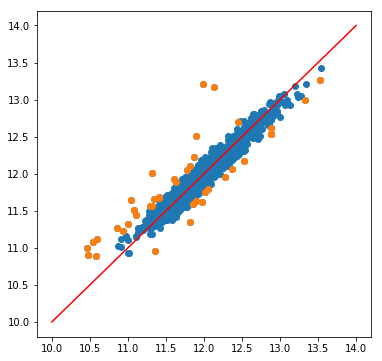

In [162]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")

**Explore outliers with ElasticNet**

In [163]:
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.13883017329962338

In [164]:
y_pred = er.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

array([  30,   88,  142,  277,  328,  410,  457,  462,  495,  523,  533,
        581,  588,  628,  632,  666,  681,  688,  710,  711,  714,  728,
        738,  774,  812,  874,  898,  916,  968,  970, 1181, 1182, 1298,
       1324, 1383, 1423, 1432, 1453])

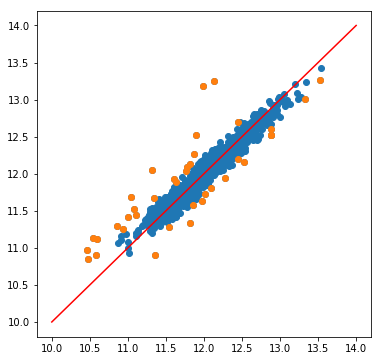

In [165]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")

**The point where the two algorithms predict poor results is used as the outlier**

In [166]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
outliers

[30,
 88,
 142,
 277,
 328,
 410,
 462,
 495,
 523,
 533,
 581,
 588,
 628,
 632,
 681,
 688,
 710,
 714,
 728,
 774,
 812,
 874,
 898,
 916,
 968,
 970,
 1181,
 1182,
 1298,
 1324,
 1383,
 1423,
 1432,
 1453]

The output format here is a bit problematic, and the outliers are manually deleted later.

**Delete outliers**

In [167]:
train = train.drop([30, 88, 142, 277, 328, 410, 462, 495, 523, 533, 581, 588, 628, 632, 681, 688, 710, 714, 728, 774, 812, 874, 898, 916, 968, 970, 1181, 1182, 1298, 1324, 1383, 1423, 1432, 1453])
y = train["SalePrice"]

# hofeshk FIX
y = np.log(y+1)

# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax

# lam = boxcox_normmax(y)
# y = boxcox1p(y, lam)

# print(f'optimal lambda: {lam}')


***Modeling*** (Use GBDT, XGBOOST, Lasso, Ridge, and combine them)

dummies

In [168]:
train_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
test_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]


In [169]:
X = train_dummies
y = y
X_score = test_dummies

!mkdir processed_top1
X.to_msgpack('processed_top1/X.msgpack')
X_score.to_msgpack('processed_top1/X_score.msgpack')
y.to_msgpack('processed_top1/y.msgpack')

mkdir: cannot create directory ‘processed_top1’: File exists


**GBDT**

In [170]:
gbr = GradientBoostingRegressor(max_depth=4, n_estimators=150)
gbr.fit(train_dummies, y)
np.sqrt(-cross_val_score(gbr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.10036155208205137

**XGB**

In [171]:
xgbr = XGBRegressor(max_depth=5, n_estimators=400)
xgbr.fit(train_dummies, y)
np.sqrt(-cross_val_score(xgbr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.10051704266055339

**Lasso**

In [172]:
lsr = Lasso(alpha=0.00047)
lsr.fit(train_dummies, y)
np.sqrt(-cross_val_score(lsr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.09072389427316198

**Ridge**

In [173]:
rr = Ridge(alpha=13)
rr.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.0916138648582849

The cross-validation score is metaphysical. Sometimes the score is increased here, but it will fall after the submission; the score is dropped here, but it is increased after the submission.

**Combined model** (I also tried stacking, which can improve the score, but the effect is not ideal)

In [174]:
train_predict = 0.1 * gbr.predict(train_dummies) + 0.3 * xgbr.predict(train_dummies) + 0.3 * lsr.predict(train_dummies) + 0.3 * rr.predict(train_dummies)


This is a combination of prediction models for the training set. The training set is first combined with the prediction model because I am going to manually modify the predicted values.

**Manually modify the predicted value** (Refer to [Top 10 (0.10943): stacking, MICE and brutal force](https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force), very effective)

**Observe the prediction effect of our model on the training set**

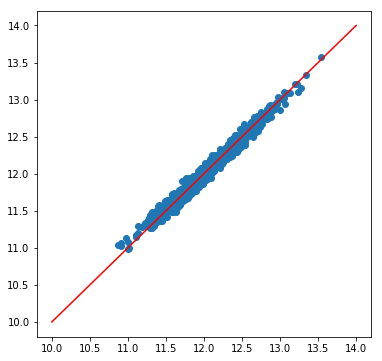

In [175]:
plt.figure(figsize=(6, 6))
plt.scatter(y, train_predict)
plt.plot(range(10, 15), range(10, 15), color="red")

You will see that the bottom point is not on the red line like the top point, indicating that the bottom point may not be predictive. You can manually adjust it and use the quantile to select the predicted value you want to adjust and adjust it. The parameters of the quantile and the multiples of the resizing can be adjusted to find the parameters that will give the best score.

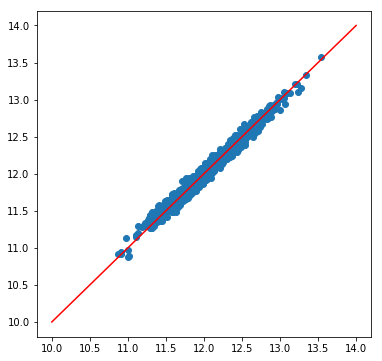

In [176]:
q1 = pd.DataFrame(train_predict).quantile(0.0042)
pre_df = pd.DataFrame(train_predict)
pre_df["SalePrice"] = train_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.99
train_predict = np.array(pre_df.SalePrice)
plt.figure(figsize=(6, 6))
plt.scatter(y, train_predict)
plt.plot(range(10, 15), range(10, 15), color="red")

**Predict and submit**

In [177]:
test_predict = 0.1 * gbr.predict(test_dummies) + 0.3 * xgbr.predict(test_dummies) + 0.3 * lsr.predict(test_dummies) + 0.3 * rr.predict(test_dummies)

q1 = pd.DataFrame(test_predict).quantile(0.0042)
pre_df = pd.DataFrame(test_predict)
pre_df["SalePrice"] = test_predict
pre_df = pre_df[["SalePrice"]]
pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] = pre_df.loc[pre_df.SalePrice <= q1[0], "SalePrice"] *0.96
test_predict = np.array(pre_df.SalePrice)

sample_submission["SalePrice"] = np.exp(test_predict)-1
sample_submission.to_csv("1.csv", index=False)



you can see that I finally chose a multiple of 0.96, which allowed me to achieve a good score. This submission can get a score of 0.11052, reaching top 2%.

***summarize***

**1. It is very important to fill in missing values, which can effectively improve the score. You can try different filling methods. For example, the filling of three special missing value examples of PoolQC can try different combinations.**

**2. The exploration of outliers, the outliers proposed above are not the best for this model, you can try to add new outliers, or reduce the old outliers, there will be some outlier combination for you to increase your score again.**

**3. The search for redundant features, that is the first time I built the simplest model, I found it by chance. At that time, I manually tried which feature is good, which feature is bad, and found two bad features, which have been used until the end and surprisingly useful all the time. Deleting these two features will increase the score of this model again.**

**4. It is known from Titanic that it is useful to create some new features. Many of the kernels in the house price have also created some new features, but it is not useful for this model.**

**5. Skew and PCA which many kernels mentioned are not useful for this model.**

**Finally, delete the outliers *[30, 88, 410, 462, 495, 523, 588, 628, 632, 874, 898, 968, 970, 1182, 1298, 1324, 1432]*, delete the features *LandSlope, Exterior2nd* allows this model reached 0.10955, top 1%.**